## Benchmarking NeuralNet.jl

### Load in required files for benchmarking

In [21]:
include("src/algorithms/nn.jl");
include("src/utils/parse.jl");

using Gadfly;
using CategoricalArrays;
using DataFrames;

### First let's benchmark the autoencoder sum of squared error as a function of the learning rate and number of epochs.

In [15]:
lr = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001];
epochs = [1000, 5000, 10000, 50000, 100000, 500000];
T = 5;

results = zeros(6, 6);

for alpha in 1:length(lr)
    for N in 1:length(epochs)
        println(string(lr[alpha], "\t", epochs[N]))
        res = 0.0;
        for i in 1:T
            sserr = encode_8x3x8(epochs[N], lr[alpha], ""; write_output=false, verbose=false)[4];
            res += sserr
        end
        results[N, alpha] = res / T;

    end
end

results

0.05	1000
0.05	5000
0.05	10000
0.05	50000
0.05	100000
0.05	500000
0.01	1000
0.01	5000
0.01	10000
0.01	50000
0.01	100000
0.01	500000
0.005	1000
0.005	5000
0.005	10000
0.005	50000
0.005	100000
0.005	500000
0.001	1000
0.001	5000
0.001	10000
0.001	50000
0.001	100000
0.001	500000
0.0005	1000
0.0005	5000
0.0005	10000
0.0005	50000
0.0005	100000
0.0005	500000
0.0001	1000
0.0001	5000
0.0001	10000
0.0001	50000
0.0001	100000
0.0001	500000


6×6 Array{Float64,2}:
 8.0  8.0  8.0  20.2  48.8  56.0
 1.6  8.0  8.0   8.0   8.0  45.8
 0.4  5.6  8.0   8.0   8.0  19.4
 0.0  0.0  1.2   7.8   8.0   8.0
 0.0  0.0  0.2   4.8   8.0   8.0
 0.0  0.0  0.0   0.0   1.6   8.0

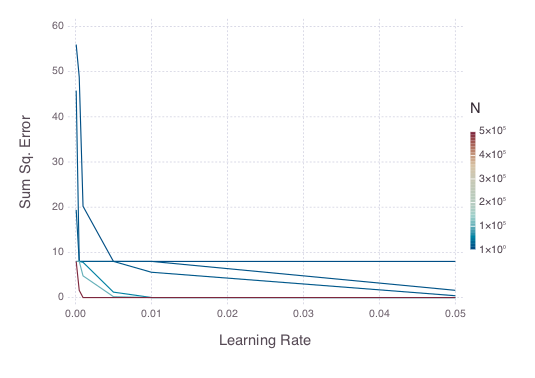

In [57]:
resultdf = DataFrame(sserr = results[1,:], lr = lr, N=epochs[1])
resultdf = vcat(resultdf, DataFrame(sserr = results[2,:], lr=lr, N=epochs[2]))
resultdf = vcat(resultdf, DataFrame(sserr = results[3,:], lr=lr, N=epochs[3]))
resultdf = vcat(resultdf, DataFrame(sserr = results[4,:], lr=lr, N=epochs[4]))
resultdf = vcat(resultdf, DataFrame(sserr = results[5,:], lr=lr, N=epochs[5]))
resultdf = vcat(resultdf, DataFrame(sserr = results[6,:], lr=lr, N=epochs[6]))

plot(resultdf, y="sserr", x="lr", color="N", Geom.line, Guide.ylabel("Sum Sq. Error"), Guide.xlabel("Learning Rate"))

Using the optimal parameters we found in the previous section, let's look at the hidden layer's representation of the input.

In [3]:
alpha = 0.05
N = 100000
h_out = encode_8x3x8(N, alpha, ""; write_output=false, verbose=false)[3];
h_out

8×3 Array{Float64,2}:
 0.943012    0.987183    0.00584752
 0.994185    0.986761    0.990468  
 0.923276    0.00458667  0.979986  
 0.0150614   0.971213    0.990424  
 0.00729402  0.973194    0.0706169 
 0.00676055  0.0171775   0.822166  
 0.980623    0.0289271   0.0374664 
 0.0387514   0.0190166   0.00535882

## Now let's turn to the neural net where we will benchmark the size of the hidden layer first. 

In [18]:
pos_seq_fp = "data/rap1-lieb-positives.txt";
total_seq_fp = "data/yeast-upstream-1k-negative.fa";
test_fp = "data/rap1-lieb-test.txt";

tdata, labels = parse_input(pos_seq_fp, total_seq_fp; balance=1);

In [12]:
hl_sizes = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12];
T = 5
preds = zeros(length(hl_sizes))

for hl_size in 1:length(hl_sizes)
    pred = 0.0
    println(hl_sizes[hl_size]);
    for i in 1:T
        pred += nn_3layer(tdata, labels, hl_size, 1000, 0.05, "")[5]
    end
    preds[hl_size] = pred / T
end
    
plot(x=hl_sizes, y=preds, Guide.xlabel("Hidden Layer Size"), Guide.ylabel("Average Predictive Ability"))

3
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Sum of Squared Error: 0.0
Final Prediction Accuracy: 1.0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Sum of Squared Error: 137.0
Final Prediction Accuracy: 0.75
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Sum of Squared Error: 137.0
Final Prediction Accuracy: 0.75
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Sum of Squared Error: 0.0
Final Prediction Accuracy: 1.0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Sum of Squared Error: 137.0
Final Prediction Accuracy: 0.75
4
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Sum of Squared Error: 137.0
Final Pr

Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Sum of Squared Error: 0.0
Final Prediction Accuracy: 1.0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Sum of Squared Error: 137.0
Final Prediction Accuracy: 0.75


### Now let's evaulate the effect of training set bias on our ability to train the network.

1
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3000
Sum of Squared Error: 0.0
Final Prediction Accuracy: 1.0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3000
Sum of Squared Error: 137.0
Final Prediction Accuracy: 0.5
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 16

Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3000
Sum of Squared Error: 0.0
Final Prediction Accuracy: 1.0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3000
Sum of Squared Error: 0.0
Final Prediction Accuracy: 1.0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700


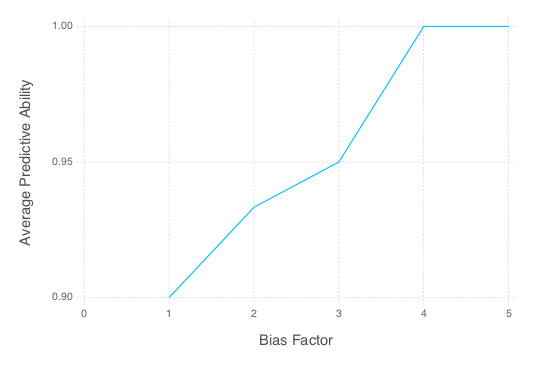

In [6]:
biases = [1, 2, 3, 4, 5]
T = 5
preds = zeros(length(biases))

for bias in 1:length(biases)
    pred = 0.0
    println(biases[bias])
    for i in 1:T
        tdata, labels = parse_input(pos_seq_fp, total_seq_fp; balance=biases[bias]);
        pred += nn_3layer(tdata, labels, 11, 3000, 0.05, "")[5]
    end
    preds[bias] = pred / T
end

plot(x=biases, y=preds, Guide.xlabel("Bias Factor"), Guide.ylabel("Average Predictive Ability"), Geom.line)

### Finally, let's find the optimal set of learning parameters using cross-validation.

In [5]:
Ns = [1000, 3000, 5000];
alphas = [0.05, 0.01, 0.005, 0.001];

results = zeros(3, 4);

for i in 1:length(Ns)
    for j in 1:length(alphas)
        println("$(Ns[i]), $(alphas[j])")
        fpred = train_nn(tdata, labels, 11, Ns[i], alphas[j], ""; write_output = false, verbose = false, C=10);
        results[i, j] = fpred
    end
end

results

1000, 0.05
Cross Validation Round: 1
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Accuracy: 0.5537190082644629
Cross Validation Round: 2
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Accuracy: 0.46564885496183206
Cross Validation Round: 3
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Accuracy: 1.0
Cross Validation Round: 4
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Accuracy: 0.4827586206896552
Cross Validation Round: 5
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Accuracy: 0.4715447154471545
Cross Validation Round: 6
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Accuracy: 0.991869918699187
Cross Va

Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3000
Accuracy: 0.9833333333333333
Cross Validation Round: 5
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3000
Accuracy: 0.9917355371900827
Cross Validation Round: 6
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3

Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3000
Accuracy: 0.4846153846153846
Cross Validation Round: 5
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3000
Accuracy: 0.5078125
Cross Validation Round: 6
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3000
Accuracy: 0.9920634920634921
Cross Validation Round: 

Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3000
Epoch: 3100
Epoch: 3200
Epoch: 3300
Epoch: 3400
Epoch: 3500
Epoch: 3600
Epoch: 3700
Epoch: 3800
Epoch: 3900
Epoch: 4000
Epoch: 4100
Epoch: 4200
Epoch: 4300
Epoch: 4400
Epoch: 4500
Epoch: 4600
Epoch: 4700
Epoch: 4800
Epoch: 4900
Epoch: 5000
Accuracy: 0.9834710743801653
Cross Validation Round: 4
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3000
Epoch: 3100
Epoch: 3200
Epoch: 3300
Epoch: 3400
Epoch: 3500
Epoch: 3600
Epoch: 3700
Epoch: 3800
Epoch: 3900
Epoch: 4000
Epoch:

Epoch: 5000
Accuracy: 0.9920634920634921
Cross Validation Round: 6
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3000
Epoch: 3100
Epoch: 3200
Epoch: 3300
Epoch: 3400
Epoch: 3500
Epoch: 3600
Epoch: 3700
Epoch: 3800
Epoch: 3900
Epoch: 4000
Epoch: 4100
Epoch: 4200
Epoch: 4300
Epoch: 4400
Epoch: 4500
Epoch: 4600
Epoch: 4700
Epoch: 4800
Epoch: 4900
Epoch: 5000
Accuracy: 0.9833333333333333
Cross Validation Round: 7
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2

Epoch: 3200
Epoch: 3300
Epoch: 3400
Epoch: 3500
Epoch: 3600
Epoch: 3700
Epoch: 3800
Epoch: 3900
Epoch: 4000
Epoch: 4100
Epoch: 4200
Epoch: 4300
Epoch: 4400
Epoch: 4500
Epoch: 4600
Epoch: 4700
Epoch: 4800
Epoch: 4900
Epoch: 5000
Accuracy: 0.49193548387096775
Cross Validation Round: 9
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3000
Epoch: 3100
Epoch: 3200
Epoch: 3300
Epoch: 3400
Epoch: 3500
Epoch: 3600
Epoch: 3700
Epoch: 3800
Epoch: 3900
Epoch: 4000
Epoch: 4100
Epoch: 4200
Epoch: 4300
Epoch: 4400
Epoch: 4500
Epoch: 4600
Epoch: 4700
Epoch: 4800
Epoch: 4900
Epoch: 5000
Accuracy: 1.0
Cross Validation Round: 10
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 

3×4 Array{Float64,2}:
 0.695385  0.541355  0.473235  0.496866
 0.992615  0.634046  0.59435   0.489598
 0.991879  0.777384  0.578799  0.468524

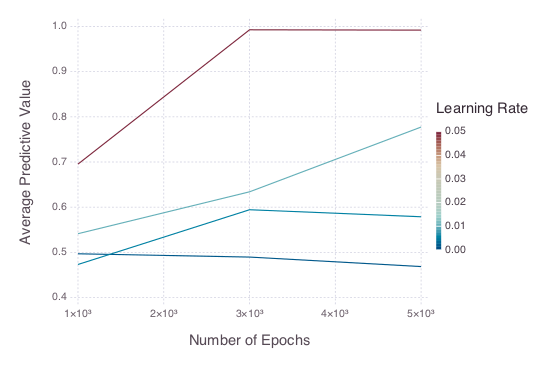

In [14]:
resultdf = DataFrame(pred = results[:,1], lr = alphas[1], N=Ns)
resultdf = vcat(resultdf, DataFrame(pred = results[:,2], lr=alphas[2], N=Ns))
resultdf = vcat(resultdf, DataFrame(pred = results[:,3], lr=alphas[3], N=Ns))
resultdf = vcat(resultdf, DataFrame(pred = results[:,4], lr=alphas[4], N=Ns))


plot(resultdf, y="pred", x="N", color="lr", Geom.line, Guide.ylabel("Average Predictive Value"), Guide.xlabel("Number of Epochs"),
    Coord.cartesian(xmin=1000, xmax=5000), Guide.colorkey(title="Learning Rate"))

### From the plot above, it's apparent that  the best combination of parameters is around $N = 5000$ and $\alpha = 0.05$. Now let's look at how sensitive these parameters are to class inbalance.

In [ ]:
biases = [1, 2, 3, 4, 5]
preds = zeros(length(biases))

N = 5000
alpha = 0.05

for bias in 1:length(biases)
    println(biases[bias])
    tdata, labels = parse_input(pos_seq_fp, total_seq_fp; balance=biases[bias]);
    preds[bias] = train_nn(tdata, labels, 11, N, alpha, ""; write_output = false, verbose = false, C=10);
end

plot(x=biases, y=preds, Guide.xlabel("Bias Factor"), Guide.ylabel("Average Predictive Ability"), Geom.line)

## Now that we've benchmarked and selected parameters, we can predict on the test data set...

In [22]:
tdata, labels = parse_training(pos_seq_fp, total_seq_fp; balance=5);
test_data = parse_testing(test_fp)

final_accur = nn_predict_on_data(tdata, labels, test_data, 11, 5000, 0.05, "final_predictions.txt"; C = 20);


Cross Validation Round: 1
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3000
Epoch: 3100
Epoch: 3200
Epoch: 3300
Epoch: 3400
Epoch: 3500
Epoch: 3600
Epoch: 3700
Epoch: 3800
Epoch: 3900
Epoch: 4000
Epoch: 4100
Epoch: 4200
Epoch: 4300
Epoch: 4400
Epoch: 4500
Epoch: 4600
Epoch: 4700
Epoch: 4800
Epoch: 4900
Epoch: 5000
Accuracy: 1.0
Cross Validation Round: 2
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoc

Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3000
Epoch: 3100
Epoch: 3200
Epoch: 3300
Epoch: 3400
Epoch: 3500
Epoch: 3600
Epoch: 3700
Epoch: 3800
Epoch: 3900
Epoch: 4000
Epoch: 4100
Epoch: 4200
Epoch: 4300
Epoch: 4400
Epoch: 4500
Epoch: 4600
Epoch: 4700
Epoch: 4800
Epoch: 4900
Epoch: 5000
Accuracy: 1.0
Cross Validation Round: 15
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3000
Epoch: 3100
Epoch

1.0